# Notebook 4: K-Normal Means
_Bryan Graham - University of California - Berkeley_

_Ec 240a: Econometrics, Fall 2016_

Let $E[Y|X] = m(X) + \sigma U$ with $U$ a standard normal random variable independent of $X$. Assume that $m(X)$  equals some linear combination of a potentially high dimensional set of basis functions (e.g., a power series in $X$). In lecture we saw how we could use Gram-Schmidt orthonormalization to generate a representation of $m(X)$ in terms of a set of orthonormal basis functions of the same dimension. This, in turn, transforms our series regression problem into a canonical K-Normal means one (cf., Wasserman (2006, Chapter 7)).
<br>
<br>
In this notebook I use K-Normal Means theory to study the conditional mean of log Earnings give years of completed schooling and AFQT scores among a sample of 733 white male respondents from the NLSY79. I focus on respondents who were 18 or younger when they took the AFQT test and restrict the analysis to high school graduates. The the population of interest, therefore, is white male high school graduates born in 1962, 1963 or 1964 and resident in the United States in 1979.

In [1]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Load libraries
import numpy as np
import numpy.linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import division

In [2]:
# Directory where NLSY79_TeachingExtract.csv file is located
workdir =  '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec240a/Ec240a_Fall2016/Python/'

First we import the NLSY79_TeachingExtract.csv dataset as a pandas dataframe and select the appropriate subsample.

In [3]:
# Read in NLSY79 Extract as a pandas dataframe
nlsy79 = pd.read_csv(workdir+'NLSY79_TeachingExtract.csv') # Reading .csv as DataFrame

# Hierarchical index: household, then individual; keep indices as columns too
nlsy79.set_index(['HHID_79','PID_79'], drop=False)
nlsy79.rename(columns = {'HGC_Age28':'School'}, inplace=True)    # Renaming schooling

# Only retain non-black, non-hispanic, male NLSY79 respondents belonging to core sample
nlsy79 = nlsy79[(nlsy79.core_sample != 0) & (nlsy79.male != 0) & (nlsy79.black != 1) & (nlsy79.hispanic != 1)]

# Like in Neal and Johnson (1996), only retain respondents born in 1962 or later and hence aged
# 16 to 18 at the time of AFQT testing. Additionally require that they graduated from highschool
nlsy79 = nlsy79[(nlsy79.year_born >= 62) & (nlsy79.School >= 12)]

# Summarize age distribution of target sample
print 'Year-of-birth distribution of target sample'
print pd.value_counts(nlsy79.year_born)

# Calculate average earnings across the 1999, 2001, 2003, 2005 and 2007 calendar years
# NOTE: This is an average over non-missing earnings values
nlsy79['Earnings'] = nlsy79[["real_earnings_1997", "real_earnings_1999", "real_earnings_2001", "real_earnings_2003", \
                             "real_earnings_2005", "real_earnings_2007", "real_earnings_2009"]].mean(axis=1)

# Only retain complete cases with earnings, schooling and AFQT
nlsy79 = nlsy79[["PID_79","HHID_79","Earnings","School","AFQT"]] 
nlsy79 = nlsy79.dropna()

# Drop units with zero earnings (will evaluate to -Inf by np.log) and compute log earnings
nlsy79 = nlsy79[nlsy79.Earnings!=0]
nlsy79['LogEarn'] = np.log(nlsy79.Earnings) # Log earnings

# Basic summary statistics of nlsy79 dataframe
nlsy79.describe()

Year-of-birth distribution of target sample
62    307
63    263
64    251
Name: year_born, dtype: int64


,PID_79,HHID_79,Earnings,School,AFQT,LogEarn
count,733.000000,733.000000,733.000000,733.000000,733.000000,733.000000
mean,3497.286494,3496.601637,68569.923403,13.829468,59.995492,10.830661
std,2619.165544,2619.228555,57868.069739,2.172758,26.388355,0.888534
min,7.000000,7.000000,8.725730,12.000000,0.094000,2.166276
25%,1805.000000,1804.000000,34621.595600,12.000000,40.801998,10.452233
50%,3171.000000,3171.000000,53954.796857,13.000000,63.183998,10.895902
75%,4648.000000,4648.000000,80325.222143,16.000000,81.324997,11.293839
max,12139.000000,12137.000000,546176.494286,20.000000,100.000000,13.210697


Next we create a power series in years of schooling and AFQT scores (we first transform both variables to lie on the unit interval for numerical stability). We will work with a 6th order power series expansion, which with two covariates, includes 28 terms.

In [4]:
# Create 7th order power series in School and AFQT
SeriesTerms = np.array([[0,1,0,2,0,1,3,0,2,1,4,0,3,1,2,5,0,4,1,3,2,6,0,5,1,4,2,3,7,0,6,1,5,2,4,3],\
                        [0,0,1,0,2,1,0,3,1,2,0,4,1,3,2,0,5,1,4,2,3,0,6,1,5,2,4,3,0,7,1,6,2,5,3,4]])
# Only retain terms up to 6th order
SeriesTerms = SeriesTerms[:,0:27]
SeriesLabels = []

for p in range(np.shape(SeriesTerms)[1]):
    i = SeriesTerms[0,p]  #Exponent for School
    j = SeriesTerms[1,p]  #Exponent for AFQT
    SeriesLabels.append('Sch_'+str(i)+'_X_AFQT_'+str(j))
    nlsy79['Sch_'+str(i)+'_X_AFQT_'+str(j)]=(((nlsy79['School']-12)/8)**i)*((nlsy79['AFQT']/100)**j)

Let $G$ be our $N\times K$ matrix of basis functions. The GramSchmidt() function defined below transforms $G$ in a matrix $W$ of orthnormal columns using the inner product and norm definitions given in lecture.

In [5]:
def proj(f, g):
    # Calculate orthogonal projection of g onto f    
    return  ( np.dot(f,g) / np.dot(f,f) ) * f   
 
def GramSchmidt(G):
    
    G = np.array(G, dtype=float)   # Convert design matrix to float type
    F = np.copy(G)                 # Copy of G -- will be used to store orthogonalization
    
    # orthogonalize design matrix
    for i in range(1, G.shape[1]):            # Iterate over columns of G
        for j in range(i):                    # Iterate over columns less than current one
            F[:,i] -= proj(F[:,j], G[:,i])    # Subtract projection of g_i onto f_j for all j<i from F_i
    
    # normalize each column to have unit length
    norm_F=( (F**2).mean(axis=0) ) ** 0.5     # Row vector with sqrt root of average of the squares of each column
    W = F/norm_F                              # Normalize
    
    return W

This next snippet of code computes the MLE of $m(X)$ for $X = (School, AFQT)'$ as well its smoothed counterpart. The smoothed counterpart is based on basis function coefficients which have been shrunk toward zero. The amount of shrinkage was chosen in order to minimize Stein's unbiased estimate of risk (SURE) as described in lecture. The estimator is a simplified version of the Universal Series Estimator (USE) described in the book _Nonparametric Curve Estimation_ by Efromovich (1999). Note that many of the 28 basis function coefficients are shrunk substantially, in several cases all the way to zero. The shrinkage factor for each basis function coefficient is list in the output below.


Empirical risk minimizing amount of shrinkage of K basis
function coeffients

[0.99999323082850755, 0.99541311237289409, 0.9660681929692968, 0, 0.84254576947302195, 0.80693921396088519, 0, 0.92230461500620942, 0.7177621389796961, 0, 0.044809505559383678, 0, 0, 0, 0, 0, 0, 0.00213731843585796, 0, 0, 0, 0.34404618102409579, 0.21194598299069001, 0, 0.34927653167983597, 0, 0]


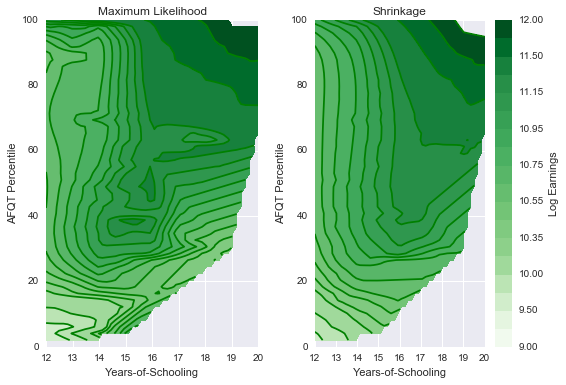

In [6]:
Y = nlsy79['LogEarn']          # Outcome variable
X = nlsy79[['School','AFQT']]

N = len(Y)

G = nlsy79[SeriesLabels]       # Basis functions
W = GramSchmidt(G)             # Orthonormalized basis functions
Z = W.T.dot(Y)/N               # K Normal Means

theta_ML = Z                   # Maximum likelihood estimate of basis function coefficients
mu_MLE   = W.dot(Z)            # MLE of m(X) 
sigma2   = np.sum((Y - mu_MLE) ** 2)/(N-len(SeriesLabels)) # MLE of sigma2

# Shrink basis function coeffients as described in lecture and very close
# to the universal series estimator (USE) of Efromovich (1999). Truncate shrinkage 
# at zero.
ShkCoef = []
for k in range(0, len(SeriesLabels)):
    ShkCoef.append(max([1-(sigma2/N)/(Z[k]**2),0]))

mu_USE = W.dot(ShkCoef*Z)     # USE estimate of m(X)

print ""
print "Empirical risk minimizing amount of shrinkage of K basis"
print "function coeffients"
print ""
print ShkCoef

# Form interpolation grid upon which to plot estimated regression surface
School_i = np.linspace(12, 20)
AFQT_i   = np.linspace(0, 100)
mu_MLE_i = plt.mlab.griddata(X['School'], X['AFQT'], mu_MLE, School_i, AFQT_i,interp='linear')
mu_USE_i = plt.mlab.griddata(X['School'], X['AFQT'], mu_USE, School_i, AFQT_i,interp='linear')


# Create a 1 x 2 array of plots, with a contour representation of (i) the MLE regression surface
# as well as (ii) its smoothed USE counterpart.
plt.figure(1)
plt.subplot(121)
surf_MLE = plt.contourf(School_i, AFQT_i,mu_MLE_i, \
                        levels = [9,9.25,9.5,9.75,10,10.25,\
                                  10.35,10.45,10.55,10.65,10.75,10.85,10.95,11.05,11.15,\
                                  11.25,11.5,11.75,12], cmap='Greens')
surf_MLE_cl = plt.contour(surf_MLE,colors = 'Green')
plt.title('Maximum Likelihood')
plt.xlabel('Years-of-Schooling')
plt.ylabel('AFQT Percentile')

plt.subplot(122)
surf_USE = plt.contourf(School_i, AFQT_i,mu_USE_i, \
                        levels = [9,9.25,9.5,9.75,10,10.25,\
                                  10.35,10.45,10.55,10.65,10.75,10.85,10.95,11.05,11.15,\
                                  11.25,11.5,11.75,12], cmap='Greens')
cb = plt.colorbar(surf_USE)
cb.set_label('Log Earnings')
surf_USE_cl = plt.contour(surf_USE,colors = 'Green')
plt.title('Shrinkage')
plt.xlabel('Years-of-Schooling')
plt.ylabel('AFQT Percentile')


# Save result
plt.tight_layout()
plt.savefig(workdir+'Fig_KNormalMeansExample.png')

The two regression surfaces are depicted as countour plots in the figure above. There are no contours in the lower-right-hand region of the figures, since this is outside the support of the sample.
<br>
<br>
The two figures are based on the same set of 28 basis functions, with the difference being that the basis function coefficients used to draw the right hand figure have been shrunk toward zero. Note that coefficient shrinkage induces smoothness in the resulting conditional mean function.
<br>
<br>
The two plots reveal several interesting features about the conditional mean of log earnings given schooling and AFQT. In particular note that the "return" to additional years of schooling is very high for individuals with high AFQT scores relative to those with low scores. Put differently, for individuals with less than 16 years of schooling (which corresponds to an undergraduate degree), earnings only weakly increase in AFQT scores.

In [7]:
# This imports an attractive notebook style from Github
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())